In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy
from geopy import Point
from geopy.distance import geodesic
import re
import geojson
import urllib
import geopandas as gpd

import plotly.graph_objects as go
import requests
import plotly.express as px

isu = Point(42.026789, -93.646802)
downtown_ames = [42.024858, -93.612847]


pd.set_option('display.max_columns', None)

### Read in Data

In [4]:
data = pd.read_csv('../../communal/Ames_Housing_Price_Data_cleaned_2.csv')

### Helper functions

In [5]:
#Calculate distance between certain points
def distance(row, other_location):
    neighborhoodLocation = Point(row['lat'],row['long'])
    return round(geodesic(neighborhoodLocation,other_location).miles,2)


#Loading the geodata for the outline of Ames
url = 'https://polygons.openstreetmap.fr/get_geojson.py?id=128947&params=0'
# request = requests.get(url)
# ames_geo_data = gpd.read_file(request.text)
ames_geo_data = gpd.read_file('ames.json')

#function for plotting geo data
def plot_ames(column, s ):
    plt.rcParams['figure.figsize'] = 15,8
    ax = ames_geo_data.plot(color = 'white', edgecolor = 'red')
    ames = sns.scatterplot(axes = ax, x = data['long'],\
                y = data['lat'], hue = column, size = s)
    ames

def elbow_test(f): 
    inertia = []
    K = range(1,15)
    X = data[f]
    print(X.head())
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(X)
        inertia.append(km.inertia_)

        print(inertia)


    plt.plot(K, inertia, marker= "x")
    plt.xlabel('k')
    plt.xticks(np.arange(15))
    plt.ylabel('Intertia')
    plt.title('Elbow Method')
    plt.show()

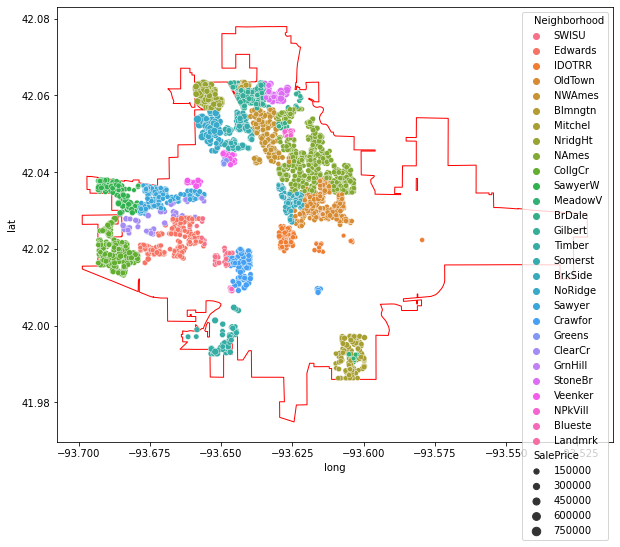

In [7]:
plot_ames(data['Neighborhood'],data['SalePrice'])
# data.groupby('Neighborhood').size().sort_values()

# Add some addtional data

In [79]:
#  Distance to college, an price per square foot
data['distFromCollege'] = data.apply(lambda row : distance(row,isu) , axis = 1 )
data['PPSF'] = data['SalePrice']/(data['1stFlrSF'] + data['2ndFlrSF'])

#Creating Data_time objects out of the given time data
data['MoSold'] = data['MoSold'].astype('str').apply(lambda n : '0' + n if len(n) == 1 else n)
data['date'] = pd.to_datetime(data['YrSold'].astype(str)  + data['MoSold'].astype(str), format='%Y%m')


0      2010-03-01
1      2009-02-01
2      2009-02-01
3      2007-11-01
4      2009-05-01
          ...    
2619   2009-05-01
2620   2009-06-01
2621   2007-08-01
2622   2007-07-01
2623   2006-09-01
Name: date, Length: 2624, dtype: datetime64[ns]

# Distance From College
### Explore the relationships between housing data and proximity to ISU

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

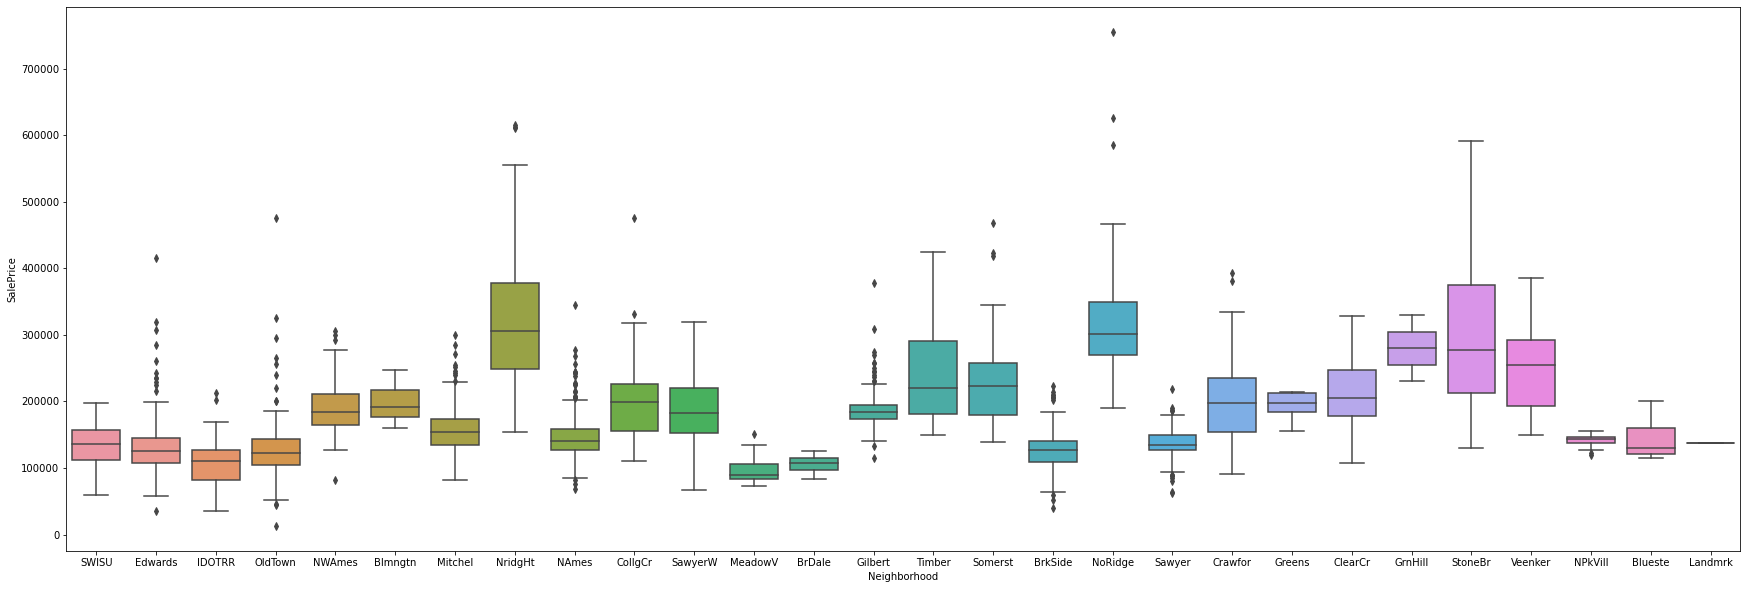

In [5]:
plt.rcParams["figure.figsize"] = (30,10)
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = data)


# Inspecting Price per Square Footage

In [6]:
data['PricePerSF'] = data.SalePrice/ data.GrLivArea

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

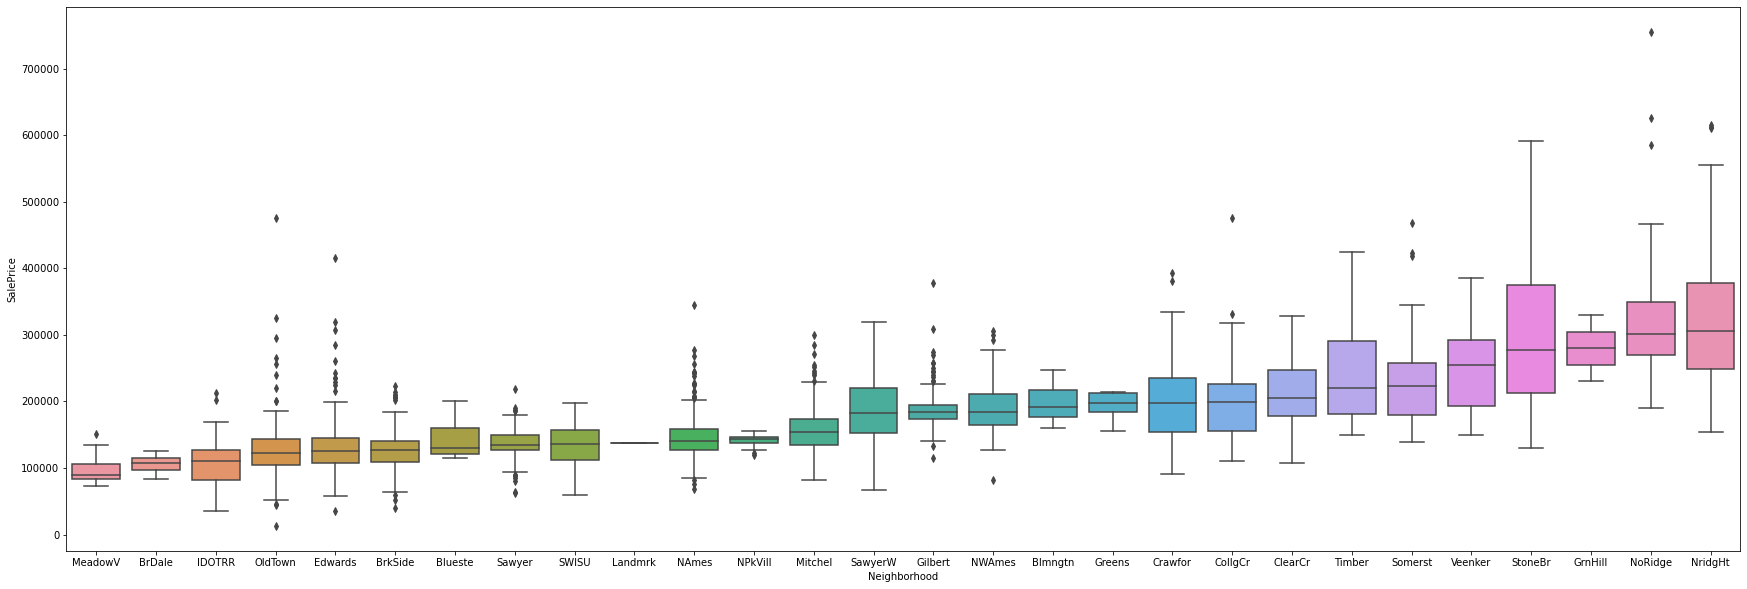

In [360]:
my_order = data.groupby('Neighborhood').SalePrice.median().sort_values().index
my_order
sns.boxplot(x = 'Neighborhood'  , y = 'SalePrice', data = data, order = my_order)

Which of the house styles, ranch or colonial, is more popular in terms of the house prices?

# Non-Normality of the Predicted Variable, SalePrice
The sale Price is not very normal. The log is certainly more normal, but we sacrifice clarity of the model for normality

Text(0.5, 0, 'log SalePrice')

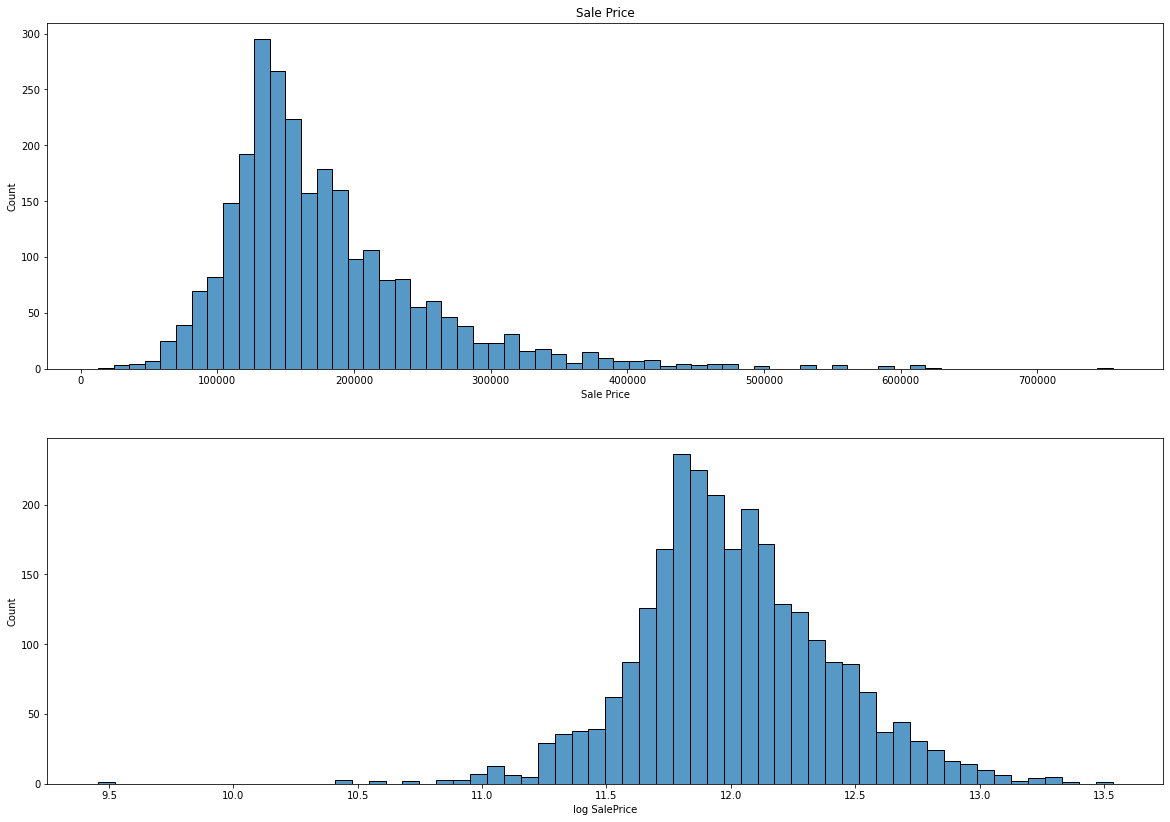

In [10]:
#Here we see that the distribution of the sale prices is skewed right
_ , axes = plt.subplots(2, figsize=(20, 14))

sns.histplot( x = data['SalePrice'], ax = axes[0])
axes[0].set_title('Sale Price')
axes[0].set_xlabel('Sale Price')
sns.histplot(x = np.log(data['SalePrice']),ax = axes[1])
axes[1].set_xlabel('log SalePrice')


# Normality of Price Per Square Feet

<AxesSubplot:xlabel='PPSF', ylabel='Count'>

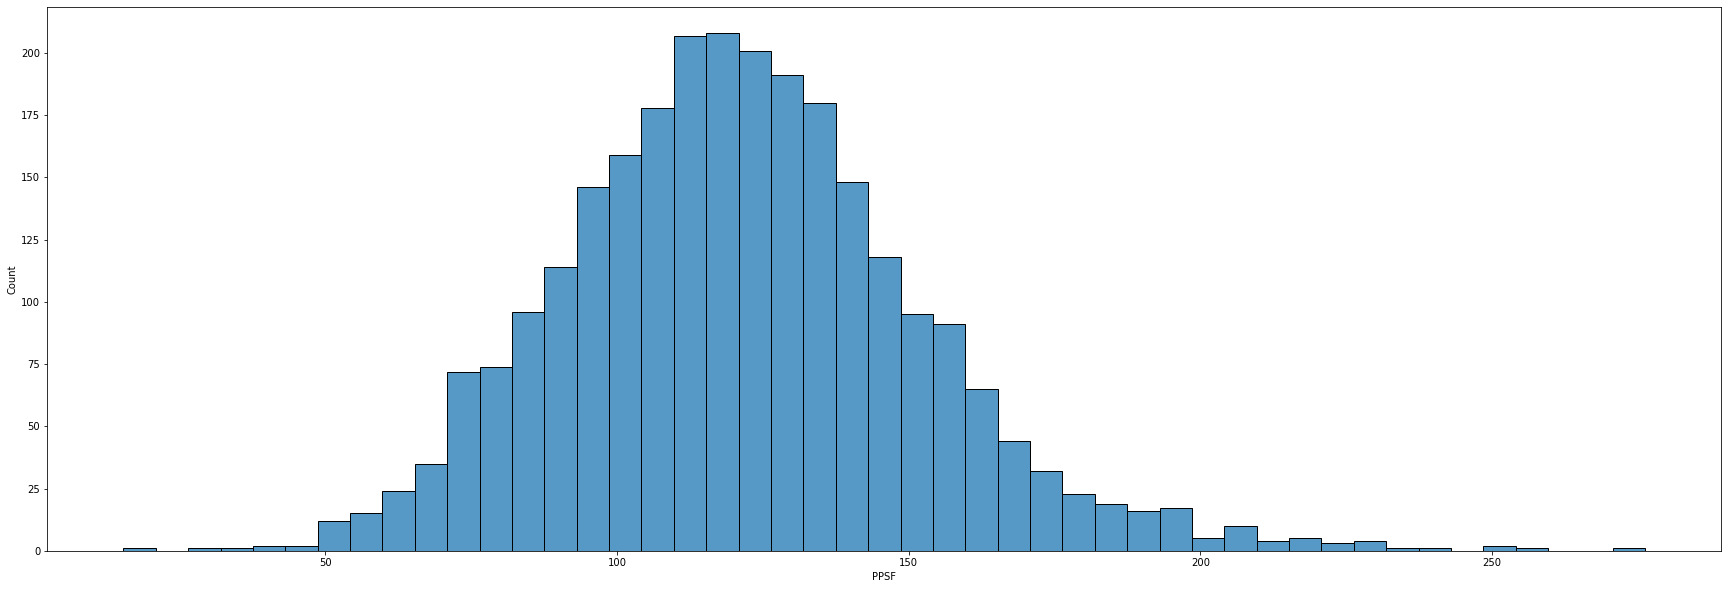

In [11]:
#The price per square footage (where square footage is the sum of the first and second floor)
# seems pretty normal
sns.histplot(x = data['PPSF'])

# Plotting every feature against price per square footage

In [143]:
# for c in data.columns:
#     sns.scatterplot(x = data[c], y = data['PPSF'])
#     plt.savefig(f'ppsf_vs_everything/ppsf_vs_{c}.pdf')
#     plt.clf()

# What features of a garage result in a higher price for the house?

#### Features vs SalePrice

# Plotting lat long data to try and see trends

In [101]:
# y , x = data['lat'], data['long']

<AxesSubplot:xlabel='long', ylabel='lat'>

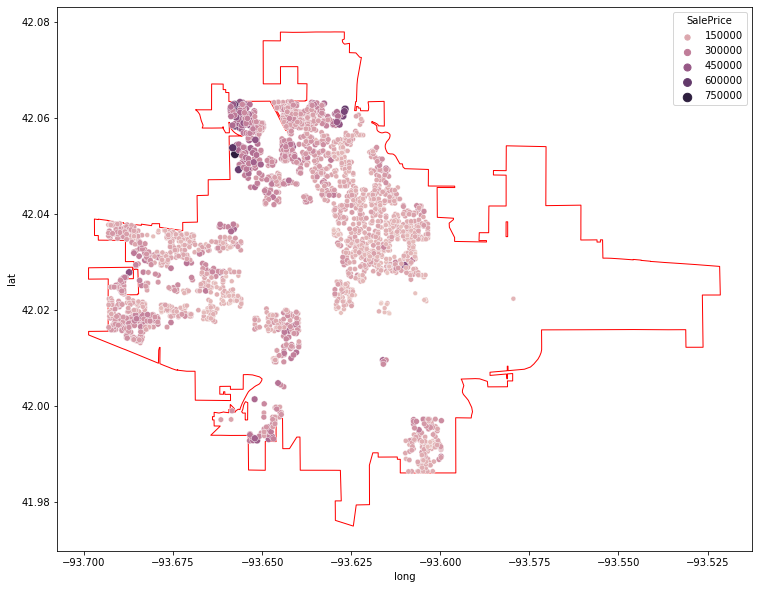

In [317]:
ax = ames_geo_data.plot(color = 'white', edgecolor = 'red')



ames = sns.scatterplot(axes = ax, x = data['long'],\
                y = data['lat'], hue = data['SalePrice'], size = data.SalePrice)

ames

In [144]:
# for c in data.columns:
#     plot = plot_ames(c)
#     plt.savefig(f'ames_plots/ames_plot_of_{c}.pdf')
#     plt.clf()
#     print(c, end = '\r')

<AxesSubplot:xlabel='long', ylabel='SalePrice'>

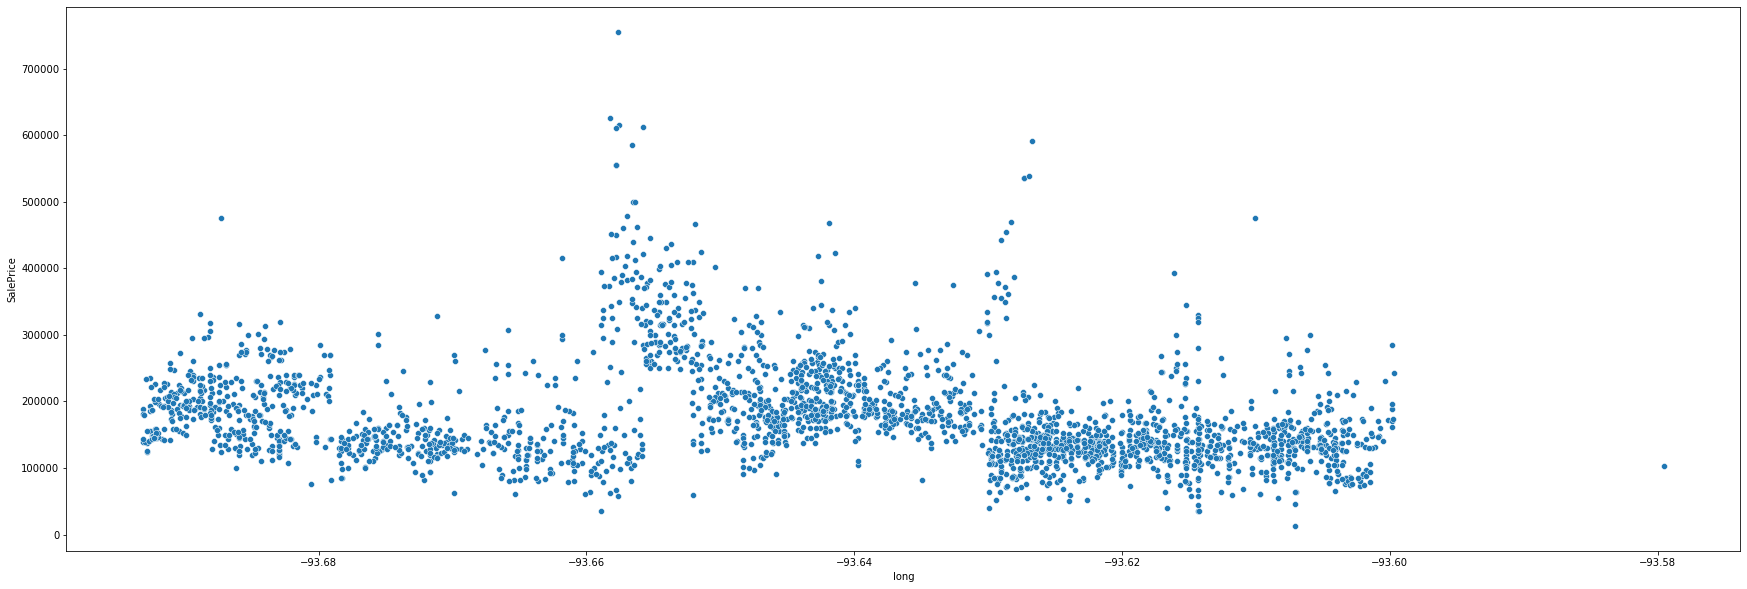

In [19]:
# Here we look at price based on longitudinal data
sns.scatterplot(data = data, x = 'long', y = 'SalePrice')

<AxesSubplot:xlabel='lat', ylabel='SalePrice'>

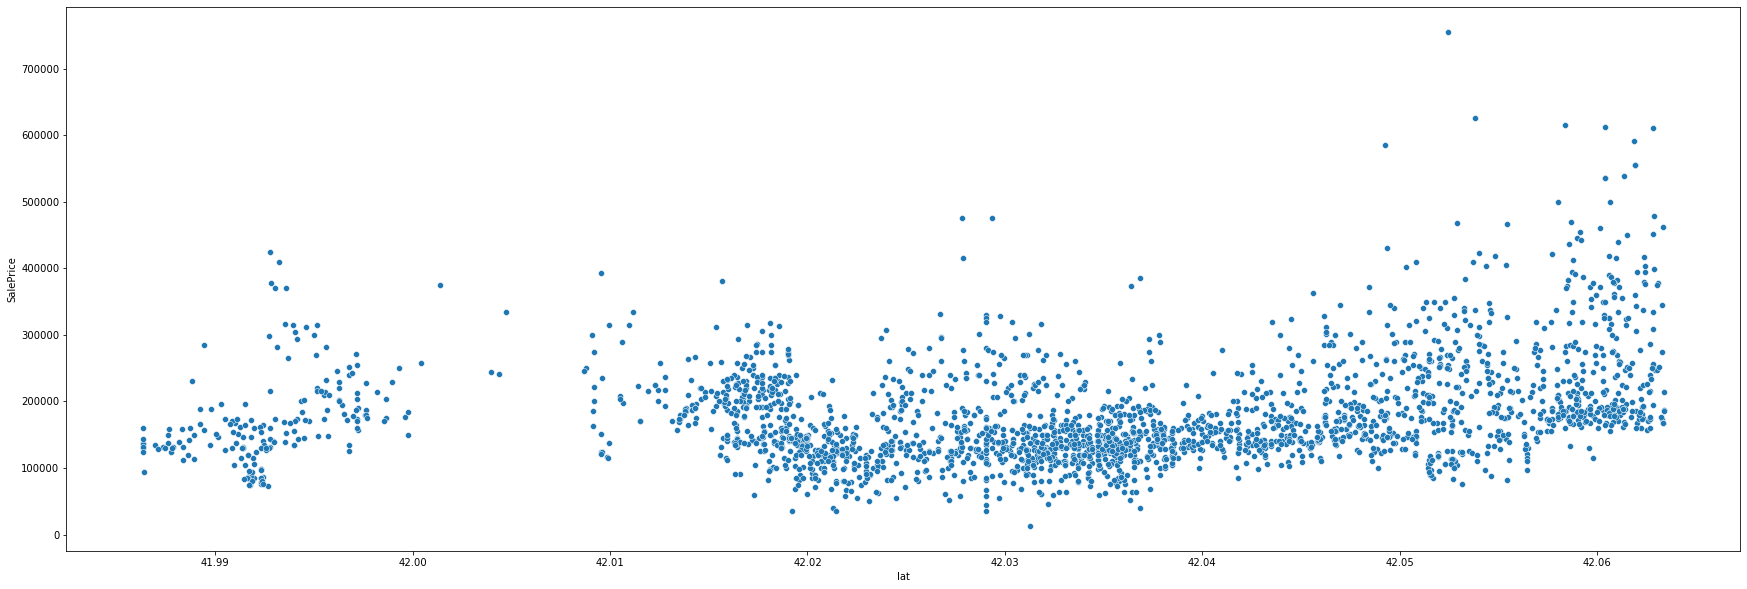

In [20]:
#here we look at price based on longitude data
sns.scatterplot(data= data, x = 'lat', y = 'SalePrice')

# Time Series Analysis

<AxesSubplot:xlabel='date', ylabel='SalePrice'>

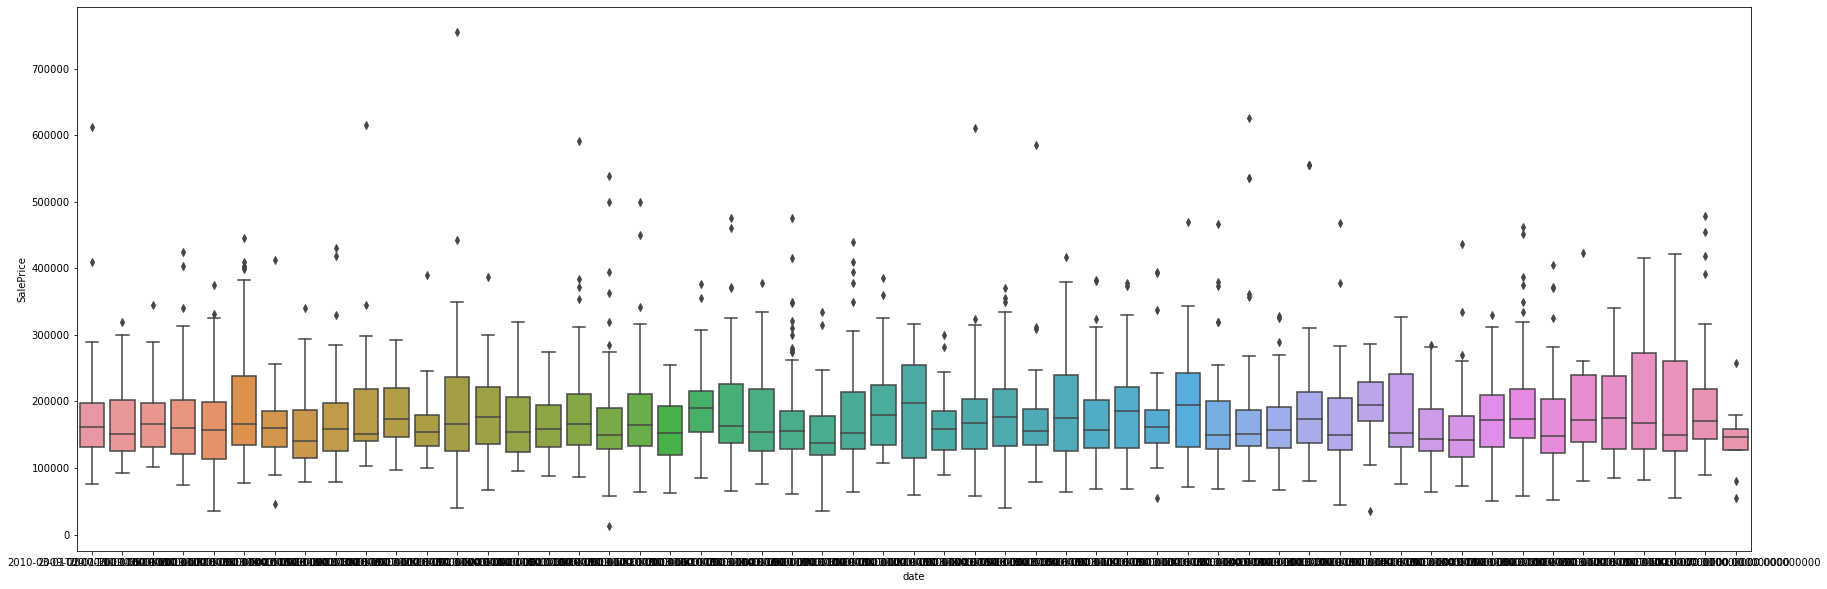

In [593]:
sns.boxplot(data = data, x = 'date', y = 'SalePrice')

# Distance from Artery

<AxesSubplot:xlabel='distFromArtery', ylabel='PPSF'>

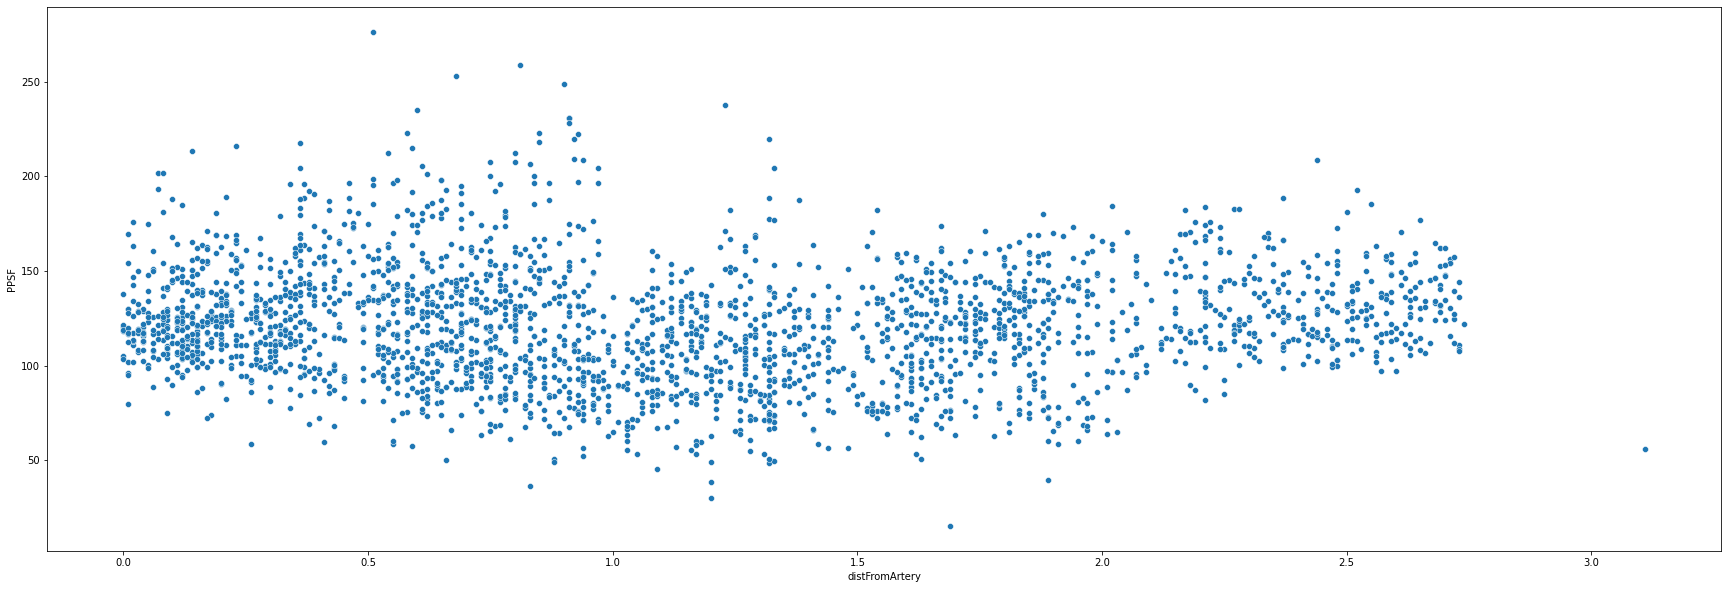

In [318]:
data['distFromArtery'] = data.apply(lambda r : distance(r, Point(r['lat'], -93.640)), axis = 1)
# data.distFromArtery.sort_values(ascending = True)
sns.scatterplot(data = data, x = 'distFromArtery', y = 'PPSF')

## Distance from ISU

# Correlation

<AxesSubplot:>

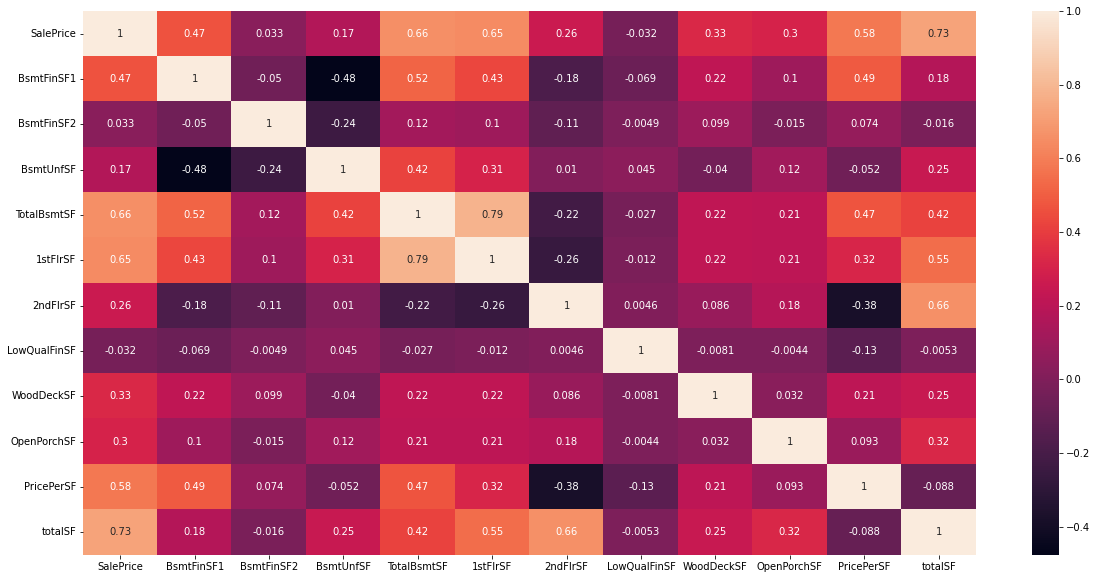

In [108]:
sns.heatmap(sf.corr(), annot = True)

<AxesSubplot:>

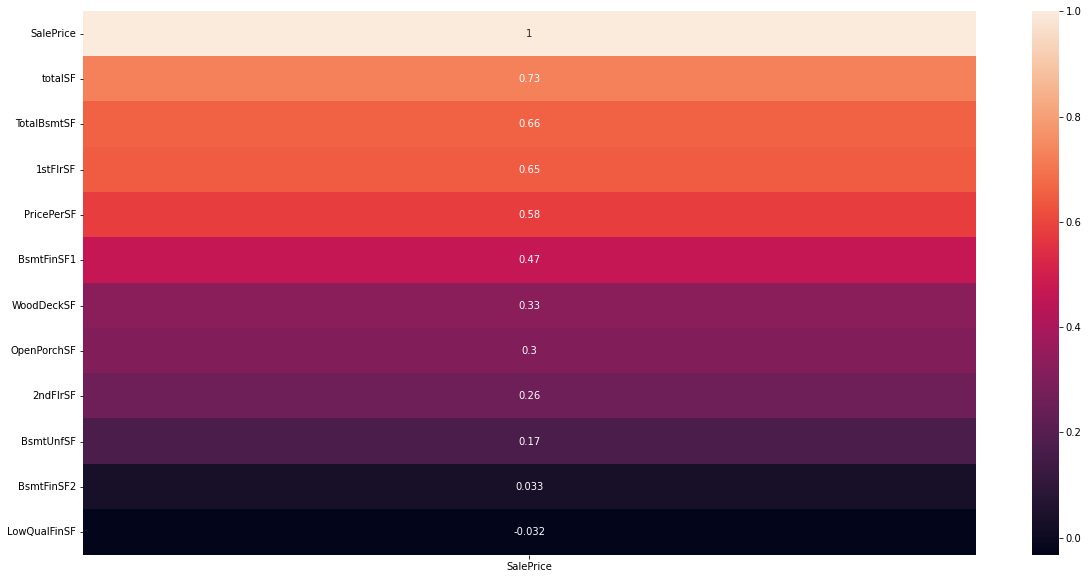

In [121]:
sns.heatmap(sf.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False), annot = True)

In [165]:
from sklearn.linear_model import Lasso

In [215]:
alphas = np.linspace(.001,200,num = 20)
coefs = []
for alpha in alphas:
    lasso.set_params(alpha = alpha, normalize = True)
    lasso.fit(data[continuous], data[['SalePrice']])
    lasso.score(data[continuous], data[['SalePrice']])
    coefs.append(lasso.coef_)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 973736810002.5233, tolerance: 1506141295.56257
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 1.0, 'Change of Lasso Slopes Varying Alpha')

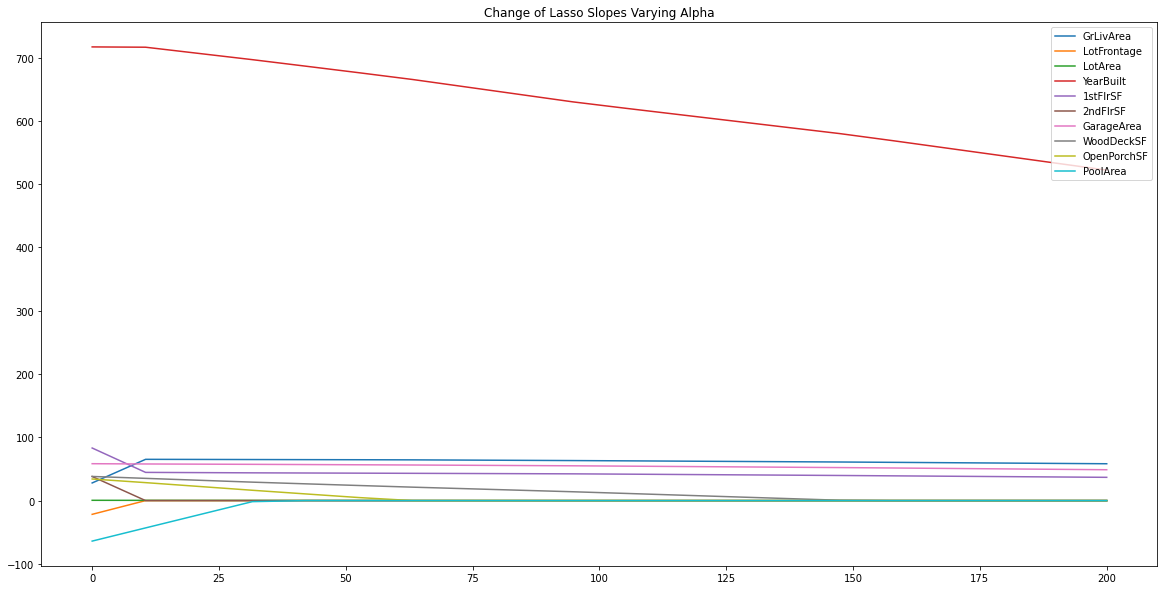

In [219]:
for name in c.columns:
    plt.plot(alphas, c[name], label=name)
    
plt.legend(loc=1)    
plt.title('Change of Lasso Slopes Varying Alpha')

# OverAll House Quality

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

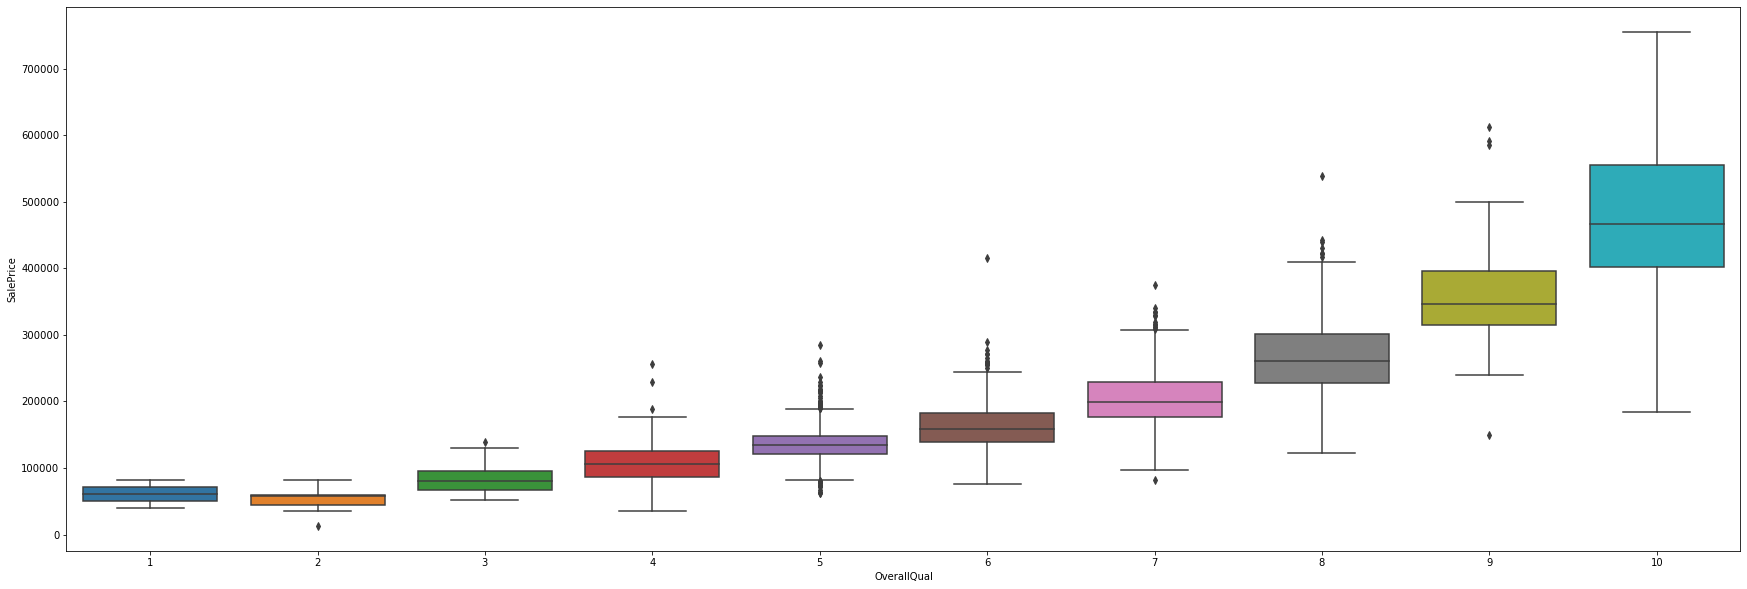

In [151]:
sns.boxplot(x = data['OverallQual'], y = data['SalePrice'])

# Lasso Regression on Garage Data

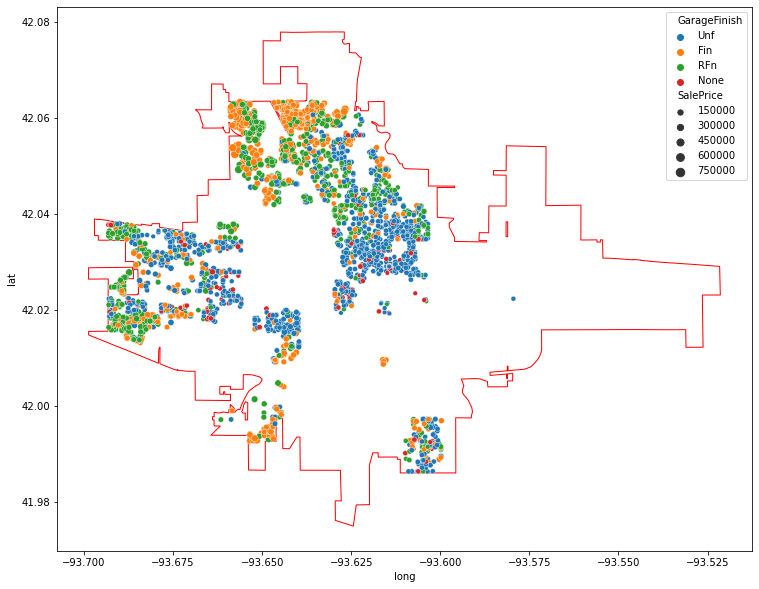

In [218]:
data.filter(regex = 'Garage').value_counts()
plot_ames(data['GarageFinish'], s = data['SalePrice'])

In [307]:
from sklearn.linear_model import Lasso
lasso = Lasso()
alphas = np.linspace(1e-3,200,num=500)

In [369]:
def run_lasso(d, alphas):
    
    coefs = []
    for alpha in alphas:
        lasso.set_params(alpha = alpha,normalize = True)
        lasso.fit(d,data['SalePrice'])
        lasso.score(d,data['SalePrice'])
        coefs.append(lasso.coef_)
    
    
    coefs = pd.DataFrame(np.array(coefs), columns=d.columns)

    for name in coefs.columns:
        plt.plot(alphas,coefs[name], label = name)
    
    
    plt.legend(loc=1,prop={'size': 20})    
    plt.title('Change of Ridge Slopes Varying Alpha')
        
    
    
    

In [383]:
neighborhood_dummies = pd.get_dummies(data.Neighborhood, drop_first=True)

/Users/charlesphillips/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1785018153775.955, tolerance: 1506141295.56257
  model = cd_fast.enet_coordinate_descent(


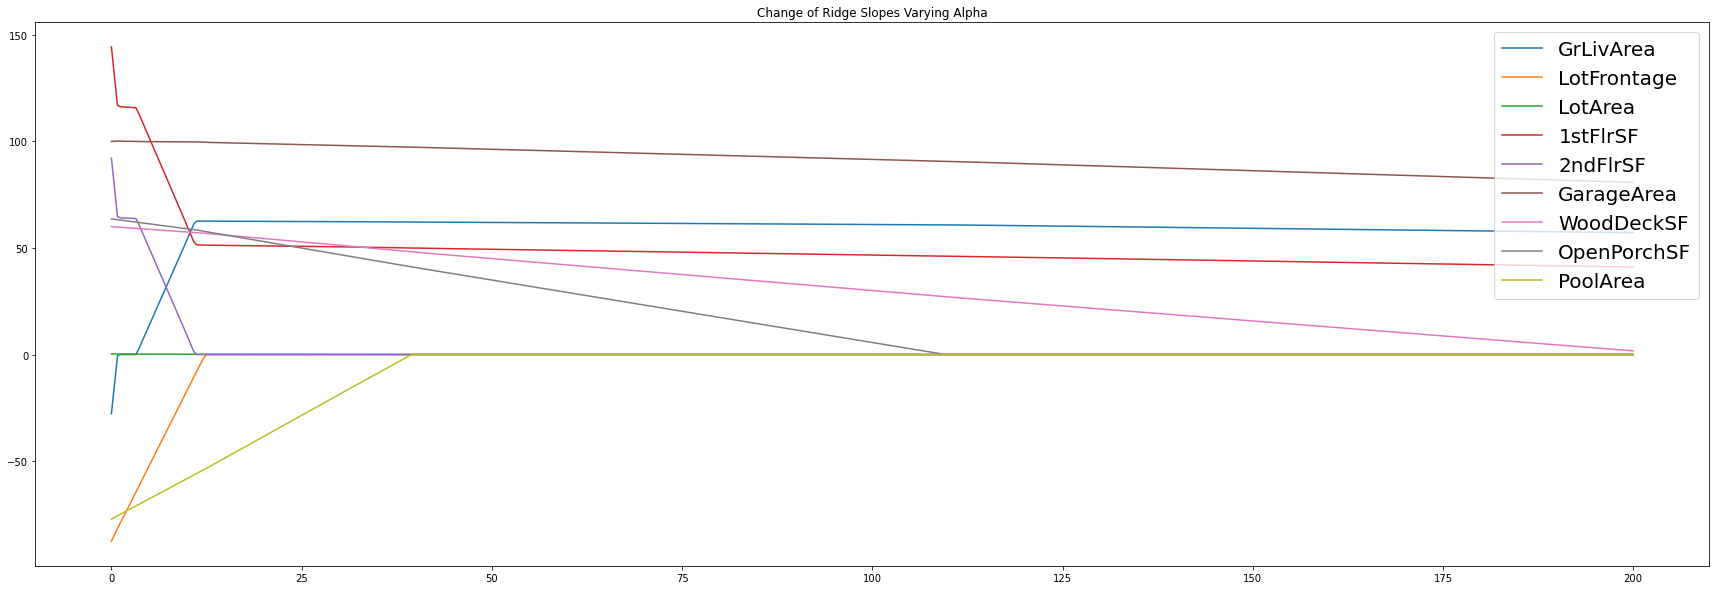

In [380]:
continuous = ['GrLivArea', 'LotFrontage', 'LotArea', '1stFlrSF','2ndFlrSF','GarageArea','WoodDeckSF','OpenPorchSF','PoolArea']
run_lasso(data[continuous], alphas = alphas)


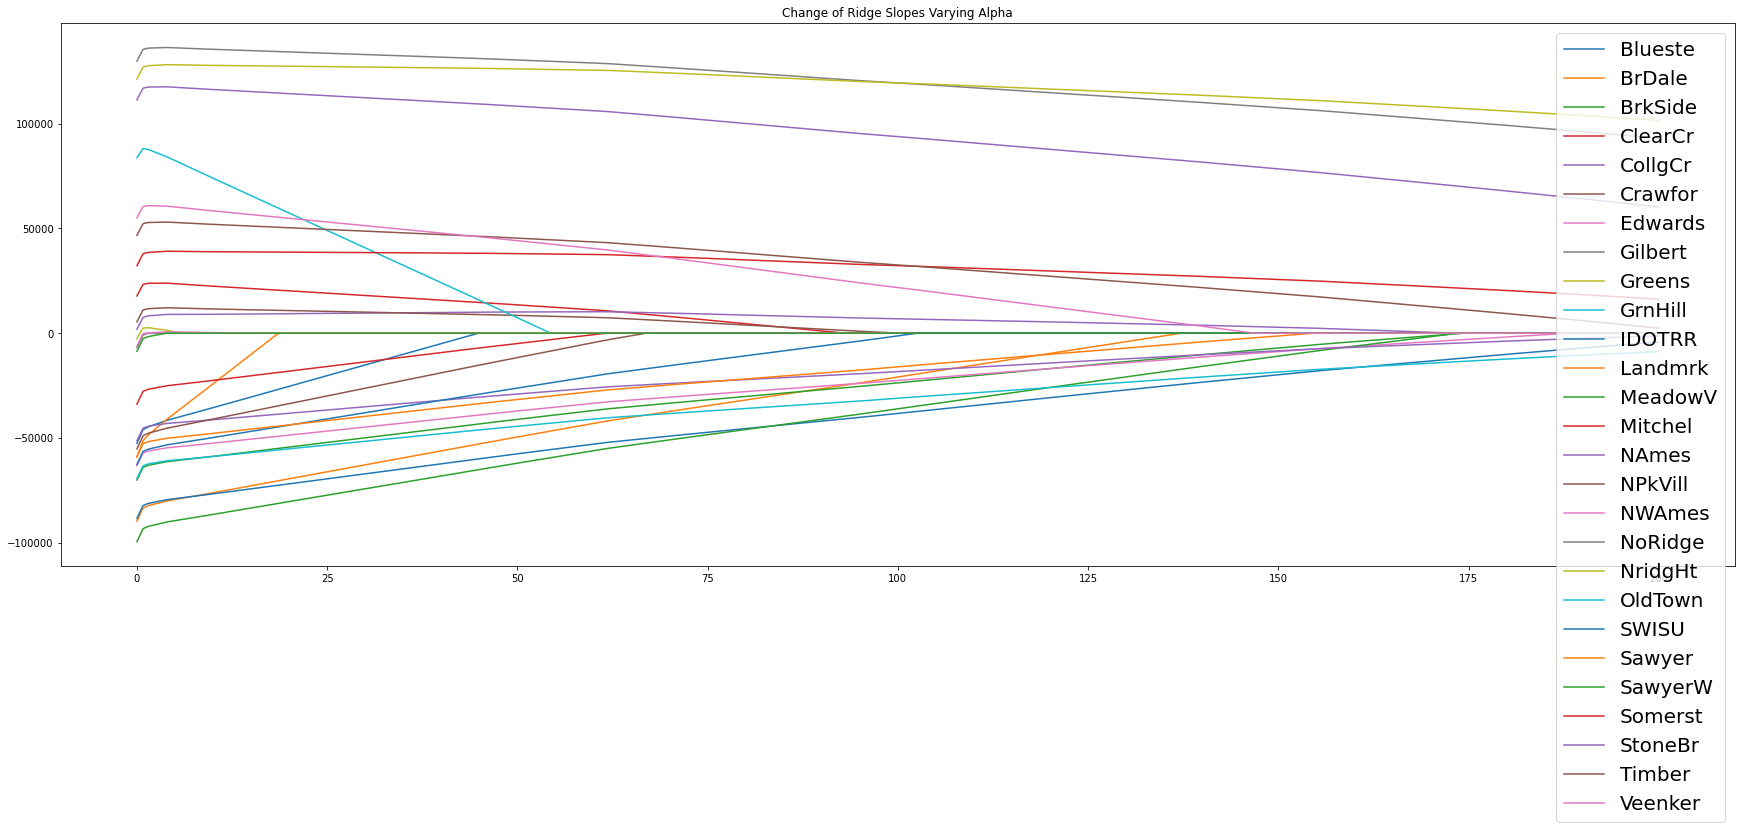

In [392]:
run_lasso(neighborhood_dummies,alphas)

# Clustering

In [343]:
from itertools import combinations
neighborhood_combinations = combinations(data.Neighborhood.unique(),2)

for i, combo in enumerate(neighborhood_combinations):
    sns.histplot(data[data.Neighborhood == combo[0]], x = 'SalePrice', color = 'r', label = combo[0],stat = 'density')
    sns.histplot(data[data.Neighborhood == combo[1]], x = 'SalePrice', color = 'b',alpha = .4, label = combo[1], stat = 'density')
    plt.legend()
    plt.savefig(f'comparing_neighborhoods/{combo[0]}and{combo[1]}.pdf')
    plt.clf()
    print(f'{combo[0]} and {combo[1]}  {i}', end = '\r')

    

<Figure size 2160x720 with 0 Axes>

In [406]:
kmean_data = pd.concat((data[continuous], pd.Series(kmean)),axis = 1)

# KMEANS to try and group neighborhoods

In [588]:
km = KMeans(8).fit_predict(data[factors])

In [589]:
data['km'] = km

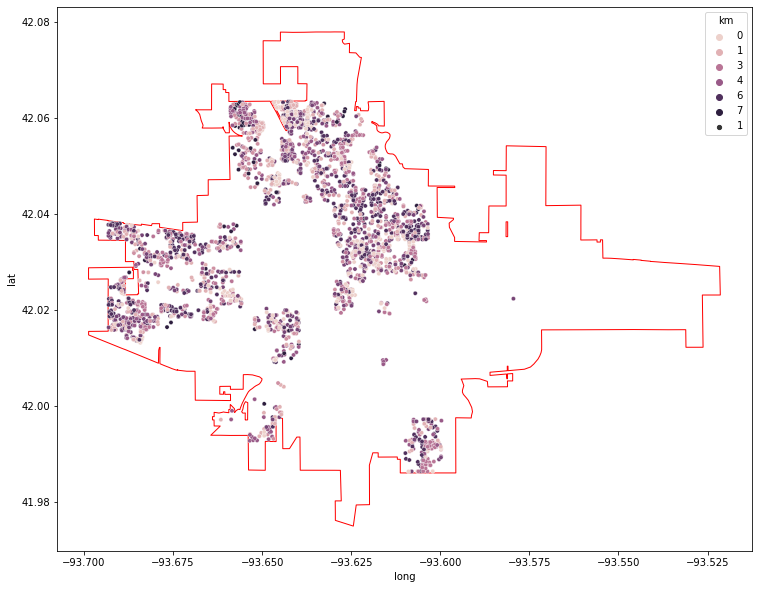

In [590]:
plot_ames(data['km'],1)

   1stFlrSF  OverallQual  YearBuilt  GrLivArea
0       856            6       1939        856
1      1049            5       1984       1049
2      1049            5       1984       1049
3      1001            5       1930       1001
4       717            4       1900       1039


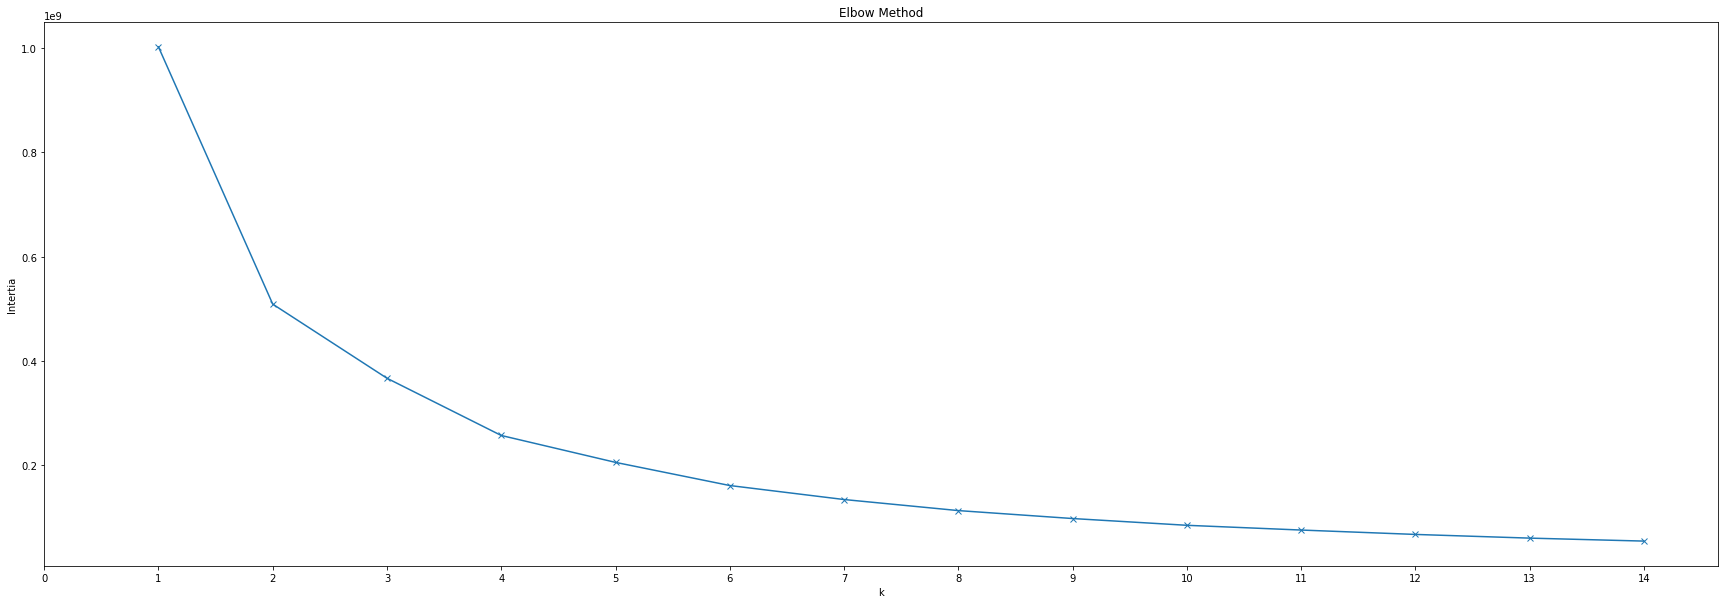

In [595]:
def elbow_test(f): 
    inertia = []
    K = range(1,15)
    X = data[f]
    print(X.head())
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(X)
        inertia.append(km.inertia_)
        
        
        
    plt.plot(K, inertia, marker= "x")
    plt.xlabel('k')
    plt.xticks(np.arange(15))
    plt.ylabel('Intertia')
    plt.title('Elbow Method')
    plt.show()
        
elbow_test(factors)

# Combining some Features

In [599]:
data.drop()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,WoodDeckSF,OpenPorchSF,PPSF
0,238.0,0.0,618.0,856.0,856,0,0,0,0,147.196262
1,552.0,393.0,104.0,1049.0,1049,0,0,0,105,132.983794
2,552.0,393.0,104.0,1049.0,1049,0,0,0,105,132.983794
3,737.0,0.0,100.0,837.0,1001,0,0,154,0,124.775225
4,0.0,0.0,405.0,405.0,717,322,0,0,0,109.720885
...,...,...,...,...,...,...,...,...,...,...
2619,0.0,0.0,952.0,952.0,952,0,0,0,98,127.100840
2620,0.0,0.0,0.0,0.0,1733,0,0,0,0,80.553953
2621,284.0,0.0,717.0,1001.0,1001,1001,0,0,0,72.427572
2622,841.0,0.0,144.0,985.0,985,857,0,193,96,118.078176


In [601]:
sns.heatmap(pd.get_dummies(data.filter(regex= 'Garage')), annot = True)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fbb1e6550d0> (for post_execute):


KeyboardInterrupt: 

In [603]:
garage_dummified = pd.get_dummies(data.filter(regex = 'Garage'))

In [607]:
garage_dummified['price'] = data['SalePrice']

<AxesSubplot:>

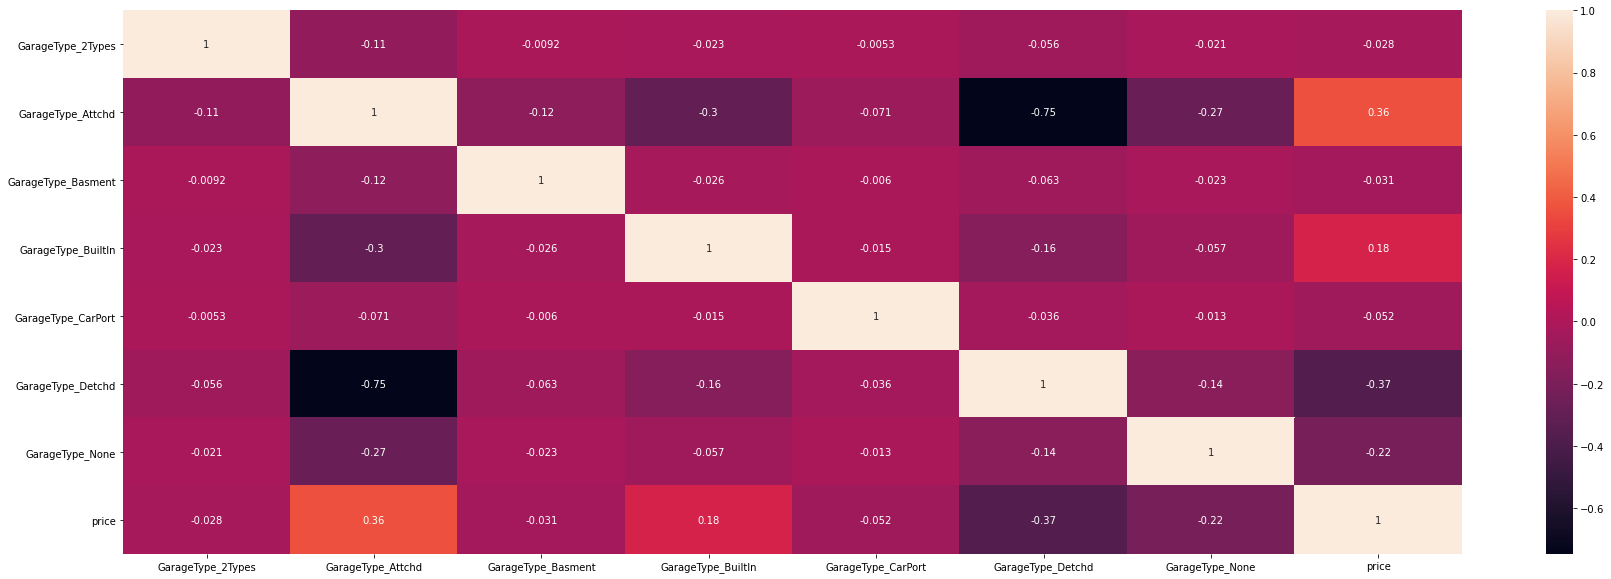

In [610]:
sns.heatmap(garage_dummified.filter(regex = '(GarageType|price)').corr(), annot = True)

In [618]:
data.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond

In [615]:
data.HeatingQC.value_counts()

Ex    1311
TA     785
Gd     440
Fa      87
Po       1
Name: HeatingQC, dtype: int64

<AxesSubplot:>

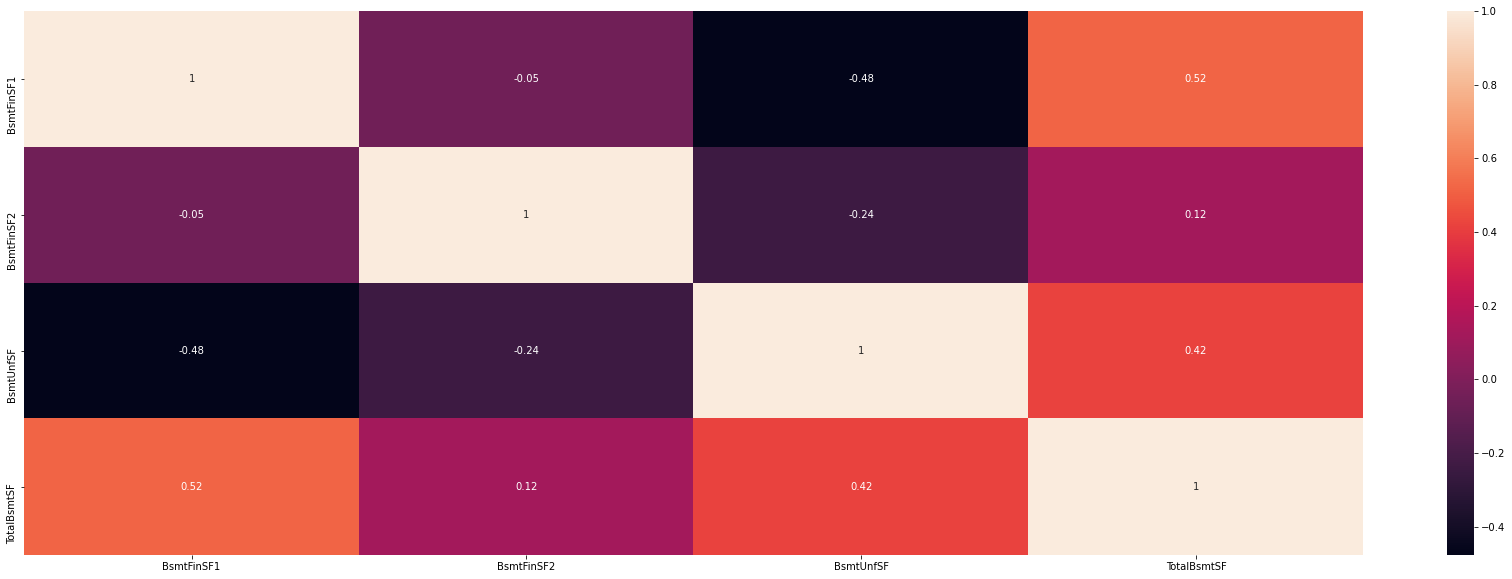

In [621]:
data.filter(regex = 'SF')
sns.heatmap(data[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF' ]].corr(), annot = True)

In [10]:
data.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lot_bucket,mean_LotFrontage,Prop_Addr,lat,long
0,909176150,856,126000,30,RL,64.9,7890,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,TA,4,Typ,1,Gd,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,None,None,None,0,3,2010,WD,Normal,"(7298.458, 8298.201]",64.93913,436 HAYWARD AVE,42.017780,-93.651452
1,905476230,1049,139500,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,None,None,None,0,2,2009,WD,Normal,"(3299.486, 4299.229]",46.15493,3416 WEST ST,42.024697,-93.664186
2,905476230,1049,139500,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,None,None,None,0,2,2009,WD,Normal,"(3299.486, 4299.229]",46.15493,3416 WEST ST,42.024697,-93.664186
3,911128020,1001,124900,30,C (all),60.0,6060,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,9,1930,2007,Hip,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,Ex,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,Gd,5,Typ,0,None,Detchd,1930.0,Unf,1.0,216.0,TA,Po,N,154,0,42,86,0,0,None,None,None,0,11,2007,WD,Normal,"(5298.972, 6298.715]",54.06015,320 S 2ND ST,42.021389,-93.614855
4,535377150,1039,114000,70,RL,80.0,8146,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,Gd,BrkTil,Fa,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,Gd,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,TA,6,Typ,0,None,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,None,None,None,0,5,2009,WD,Normal,"(7298.458, 8298.201]",64.93913,1524 DOUGLAS AVE,42.038070,-93.612065


In [16]:
data.filter(regex = '(Qual|Cond)').value_counts()

Condition1  Condition2  OverallQual  OverallCond  ExterQual  ExterCond  BsmtQual  BsmtCond  LowQualFinSF  KitchenQual  GarageQual  GarageCond  SaleCondition
Norm        Norm        7            5            Gd         TA         Gd        TA        0             Gd           TA          TA          Normal           231
                        8            5            Gd         TA         Gd        TA        0             Gd           TA          TA          Normal           143
                        5            5            TA         TA         TA        TA        0             TA           TA          TA          Normal           100
                                     6            TA         TA         TA        TA        0             TA           TA          TA          Normal            77
                        6            5            Gd         TA         Gd        TA        0             Gd           TA          TA          Normal            70
                       